# 基于LSTM的bitcoin价格预测

## 一、安装依赖

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import joblib

## 二、数据预处理

In [89]:
# 检查是否有可用的 GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# 读取数据
data = pd.read_csv('BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [132]:
# 准备数据
# feature_cols = ['Open', 'High', 'Low', 'Close']
feature_cols = ['Close']
data = data.dropna()  # 删除 NaN 行
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[feature_cols])

# 分割数据集
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [134]:
# 创建序列数据
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length, 0])  # 预测下一个 Close
    return np.array(sequences), np.array(labels)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# 转换为 Tensor 并移动到 GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1).to(device)

## 三、定义模型

In [135]:
# LSTM 模型定义，添加 Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

In [158]:
# 实例化模型、损失函数和优化器
input_size = len(feature_cols)
hidden_size = 64
num_layers = 2  # 降低层数以防过拟合
dropout_rate = 0.3  # 设置 Dropout 比例
model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate).to(device)  # 移动模型到 GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# 创建 TensorDataset 和 DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 4  # 设置批量大小
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # 不打乱数据

## 四、训练模型

In [159]:
# 训练模型
num_epochs = 100  # 设置训练轮数

for epoch in range(num_epochs):
    for inputs, targets in dataloader:  # 从 DataLoader 中获取批次数据
        inputs, targets = inputs.to(device), targets.to(device)  # 将数据移动到 GPU
        optimizer.zero_grad()  # 清空梯度
        outputs = model(inputs)  # 前向传播
        
        loss = criterion(outputs, targets.view(-1, 1))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/100], Loss: 0.025683
Epoch [2/100], Loss: 0.013787
Epoch [3/100], Loss: 0.019038
Epoch [4/100], Loss: 0.012161
Epoch [5/100], Loss: 0.014788
Epoch [6/100], Loss: 0.012291
Epoch [7/100], Loss: 0.010994
Epoch [8/100], Loss: 0.010089
Epoch [9/100], Loss: 0.009887
Epoch [10/100], Loss: 0.010199
Epoch [11/100], Loss: 0.012426
Epoch [12/100], Loss: 0.010739
Epoch [13/100], Loss: 0.010001
Epoch [14/100], Loss: 0.010074
Epoch [15/100], Loss: 0.010002
Epoch [16/100], Loss: 0.010104
Epoch [17/100], Loss: 0.009516
Epoch [18/100], Loss: 0.009037
Epoch [19/100], Loss: 0.009391
Epoch [20/100], Loss: 0.008857
Epoch [21/100], Loss: 0.008878
Epoch [22/100], Loss: 0.009034
Epoch [23/100], Loss: 0.008522
Epoch [24/100], Loss: 0.008776
Epoch [25/100], Loss: 0.008263
Epoch [26/100], Loss: 0.008347
Epoch [27/100], Loss: 0.007945
Epoch [28/100], Loss: 0.007968
Epoch [29/100], Loss: 0.008384
Epoch [30/100], Loss: 0.008627
Epoch [31/100], Loss: 0.008065
Epoch [32/100], Loss: 0.008109
Epoch [33/100], L

## 五、模型评价

In [160]:
# 测试模型
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.6f}')

Test Loss: 0.079035


In [161]:
# 将预测值反标准化
predicted_price = scaler.inverse_transform(
    np.concatenate((test_outputs.cpu().numpy(),
                    np.zeros((test_outputs.shape[0], len(feature_cols) - 1))), axis=1))[:, 0]  # 移动到 CPU

actual_price = scaler.inverse_transform(
    np.concatenate((y_test_tensor.cpu().numpy(),
                    np.zeros((y_test_tensor.shape[0], len(feature_cols) - 1))), axis=1))[:, 0]  # 移动到 CPU

# 计算 MAE, RMSE, RMSSE 和 MASE
mae = mean_absolute_error(actual_price, predicted_price)
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)

# 计算 RMSSE 和 MASE
rmsse = rmse / (np.mean(np.abs(np.diff(actual_price))) + 1e-8)  # 加小常数以防除零
mase = mae / (np.mean(np.abs(np.diff(actual_price))) + 1e-8)

# 归一化 MAE 和 RMSE
mae_normalized = mae / np.mean(actual_price) if np.mean(actual_price) != 0 else mae
rmse_normalized = rmse / np.mean(actual_price) if np.mean(actual_price) != 0 else rmse
rmsse_normalized = rmsse  # RMSSE 通常以相对形式输出，保持不变
mase_normalized = mase  # MASE 通常以相对形式输出，保持不变

print(f'Normalized Mean Absolute Error (MAE): {mae_normalized:.4f}')
print(f'Normalized Root Mean Squared Error (RMSE): {rmse_normalized:.4f}')
print(f'Relative Root Mean Squared Error (RMSSE): {rmsse:.4f}')
print(f'Mean Absolute Scaled Error (MASE): {mase:.4f}')

Normalized Mean Absolute Error (MAE): 0.4863
Normalized Root Mean Squared Error (RMSE): 0.5399
Relative Root Mean Squared Error (RMSSE): 26.3820
Mean Absolute Scaled Error (MASE): 23.7642


In [162]:
# 将价格转为 DataFrame，方便操作
prices_df = pd.DataFrame({
    'actual': actual_price,
    'predicted': predicted_price
})

# 创建分类标签
prices_df['y_test_labels'] = (prices_df['actual'].diff() > 0).astype(int)
prices_df['predicted_labels'] = (prices_df['predicted'].diff() > 0).astype(int)

# 计算准确率、召回率和 F1 分数
accuracy = accuracy_score(prices_df['y_test_labels'][1:], prices_df['predicted_labels'][1:])  # 忽略第一个 NaN 值
recall = recall_score(prices_df['y_test_labels'][1:], prices_df['predicted_labels'][1:])
f1 = f1_score(prices_df['y_test_labels'][1:], prices_df['predicted_labels'][1:])

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.4450
Recall: 0.4386
F1 Score: 0.4348


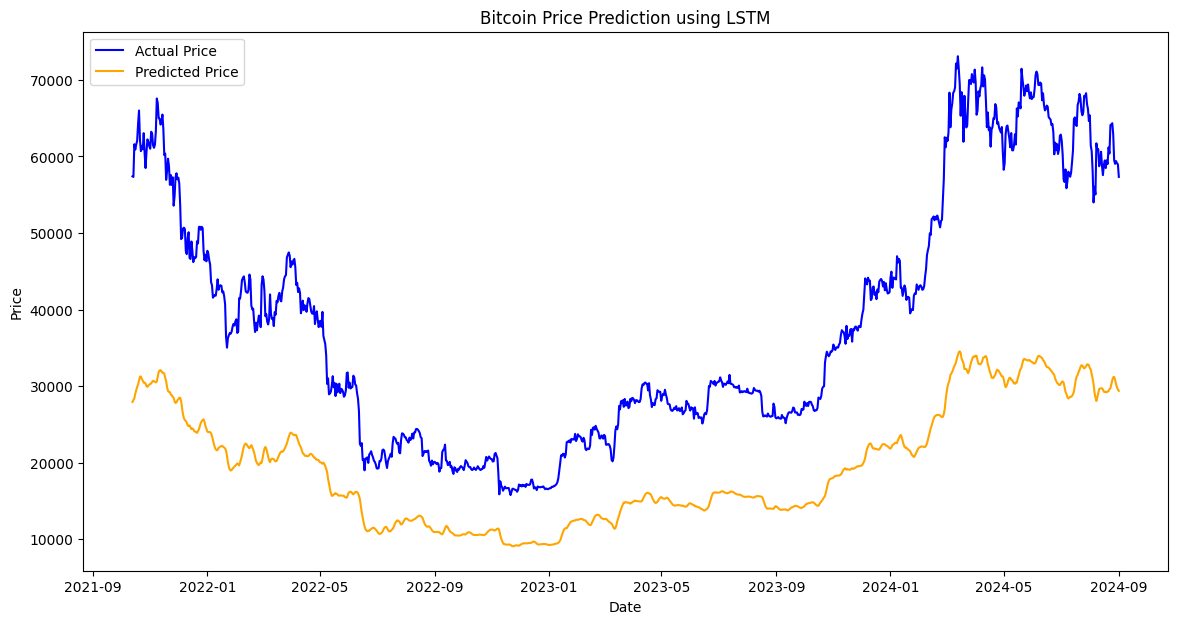

In [163]:
# # 保存训练好的模型
# torch.save(model.state_dict(), 'lstm_bitcoin_model.pth')
# print("Model saved as lstm_bitcoin_model.pth")

# 绘制预测结果
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(actual_price):], actual_price, label='Actual Price', color='blue')
plt.plot(data.index[-len(predicted_price):], predicted_price, label='Predicted Price', color='orange')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()